# Free Analysis of the Titanic Disaster

## Load and review the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import statistics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
%matplotlib inline

sns.set_style("whitegrid")
sns.set_theme()

In [2]:
data = pd.read_csv("titanic.csv")

In [3]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,Yes,"Allen, Miss. Elisabeth Walton",female,29,NaN,NaN,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1st,Yes,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1st,No,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1st,No,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1st,No,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Titanic dataset info:
Popular "Titanic" dataset often used in analytics trainings.

Original loaded data contains 1309 rows (covering only passengers, not the crew) and 14 columns. Columns meaning:
- pclass - ticket class
    * 1st = Upper
    * 2nd = Middle
    * 3rd = Lower
- survived - determins if person survived
- name - passenger name
- sex - sex
- age - age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp - number of siblings/spouses aboard
- parch - number of parents/children aboard. Some children travelled only with a nanny, therefore parch is 0 for them.
- ticket - ticket number
- fare - passenger fare
- cabin - cabin number
- embarked - port of embarkation
    * C = Cherbourg 
    * Q = Queenstown
    * S = Southampton
- boat - lifeboat (if survived)
- body - body number (if did not survive and body was recovered)
- home.dest

New columns added during the processing:
- name_prefix (object) - cut name prefix from name column
- age_range (object)- age range, split every 10 years
- class_num (integer) - numeric assignment for class:
    * 1 = 1st
    * 2 = 2nd
    * 3 = 3rd
- survived_num - numeric assignment for survival trigger:
    * 0 = dead 
    * 1 = survived
- sex_num - numeric assignment for sex:
    * 1 - female
    * 2 - male
- family_size_aboard:
    * 1 = when alone
    * value > 1 = sum of sibsp and parch plus 1

In [4]:
data.shape

(1309, 14)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   object 
 1   survived   1309 non-null   object 
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1309 non-null   object 
 5   sibsp      418 non-null    float64
 6   parch      307 non-null    float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(4), object(10)
memory usage: 143.3+ KB


### Cleaning dataset, preparing to analysys

In [6]:
data['age'].value_counts()

unknown    263
24          47
22          43
21          41
30          40
          ... 
66           1
0.6667       1
76           1
67           1
26.5         1
Name: age, Length: 99, dtype: int64

In [7]:
data['name_prefix'] = data['name'].apply(lambda x: x[(x.find(",")+1):(x.find(".")+1)].strip())

In [8]:
data['name_prefix'].value_counts()

Mr.              757
Miss.            260
Mrs.             197
Master.           61
Rev.               8
Dr.                8
Col.               4
Mlle.              2
Ms.                2
Major.             2
Capt.              1
Sir.               1
Dona.              1
Jonkheer.          1
the Countess.      1
Don.               1
Mme.               1
Lady.              1
Name: name_prefix, dtype: int64

In [9]:
def unknown_to_nan(row):
    if row == "unknown":
        return (np.NaN)
    else:
        return row

In [10]:
data['age'] = data['age'].apply(unknown_to_nan)
data['age'] = data['age'].astype("float")

In [11]:
data["age"] = data.groupby("name_prefix")['age'].transform(lambda x: x.fillna(x.mean()))

In [12]:
data['age'].value_counts()

32.252151    176
21.774207     50
24.000000     47
22.000000     43
21.000000     41
            ... 
76.000000      1
66.000000      1
80.000000      1
0.666700       1
26.500000      1
Name: age, Length: 103, dtype: int64

In [13]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       1309 non-null   object 
 1   survived     1309 non-null   object 
 2   name         1309 non-null   object 
 3   sex          1309 non-null   object 
 4   age          1309 non-null   float64
 5   sibsp        418 non-null    float64
 6   parch        307 non-null    float64
 7   ticket       1309 non-null   object 
 8   fare         1308 non-null   float64
 9   cabin        295 non-null    object 
 10  embarked     1307 non-null   object 
 11  boat         486 non-null    object 
 12  body         121 non-null    float64
 13  home.dest    745 non-null    object 
 14  name_prefix  1309 non-null   object 
dtypes: float64(5), object(10)
memory usage: 799.3 KB


In [14]:
data['sibsp'].fillna(0, inplace=True)
data['parch'].fillna(0, inplace=True)

In [15]:
data['sibsp'] = data['sibsp'].astype("int")
data['parch'] = data['parch'].astype("int")

In [16]:
data['pclass'].value_counts()

3rd    709
1st    323
2nd    277
Name: pclass, dtype: int64

In [17]:
data['sex'].value_counts()

male      843
female    466
Name: sex, dtype: int64

In [18]:
data['pclass'] = data['pclass'].astype('category')
data['sex'] = data['sex'].astype('category')
data['survived'] = data['survived'].astype('category')
data['embarked'] = data['survived'].astype('category')

In [19]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pclass       1309 non-null   category
 1   survived     1309 non-null   category
 2   name         1309 non-null   object  
 3   sex          1309 non-null   category
 4   age          1309 non-null   float64 
 5   sibsp        1309 non-null   int32   
 6   parch        1309 non-null   int32   
 7   ticket       1309 non-null   object  
 8   fare         1308 non-null   float64 
 9   cabin        295 non-null    object  
 10  embarked     1309 non-null   category
 11  boat         486 non-null    object  
 12  body         121 non-null    float64 
 13  home.dest    745 non-null    object  
 14  name_prefix  1309 non-null   object  
dtypes: category(4), float64(3), int32(2), object(6)
memory usage: 489.6 KB


In [20]:
def age_range(row):
    if row <= 10:
        return '0-10'
    elif row > 10 and row <= 20:
        return '10-20'
    elif row > 20 and row <= 30:
        return '20-30'
    elif row > 30 and row <= 40:
        return '30-40'
    elif row > 40 and row <= 50:
        return '40-50'
    elif row > 50 and row <= 60:
        return '50-60'
    elif row > 60 and row <= 70:
        return '60-70'
    elif row > 70:
        return '>70'

data['age_range'] = data['age'].apply(age_range)

In [21]:
data['survived'].value_counts()

No     809
Yes    500
Name: survived, dtype: int64

Changing values into numbers for calculating correlation:

In [22]:
def class_num(row):
    if row == '1st':
        return 1
    elif row == '2nd':
        return 2
    elif row == '3rd':
        return 3
    
data['pclass_num'] = data['pclass'].apply(class_num).astype("int")

In [23]:
def survived_num(row):
    if row == 'Yes':
        return 1
    else:
        return 0
    
data['survived_num'] = data['survived'].apply(survived_num).astype("int")

In [24]:
data['sex_num'] = data['sex'].map({"female":1, "male": 2}).astype("int")

In [25]:
data['family_size_aboard'] = (data['sibsp'] + data['parch'] + 1).astype('int')

Split data for categories - survived and not_survived:

In [26]:
survived = data[data['survived_num'] == 1]
not_survived = data[data['survived_num'] == 0]

In [27]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,name_prefix,age_range,pclass_num,survived_num,sex_num,family_size_aboard
0,1st,Yes,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,Yes,2,NaN,"St Louis, MO",Miss.,20-30,1,1,1,1
1,1st,Yes,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,Yes,11,NaN,"Montreal, PQ / Chesterville, ON",Master.,0-10,1,1,2,4
2,1st,No,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,No,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss.,0-10,1,0,1,4
3,1st,No,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,No,NaN,135.0,"Montreal, PQ / Chesterville, ON",Mr.,20-30,1,0,2,4
4,1st,No,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,No,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs.,20-30,1,0,1,4


# Describing passengers and their chances to stay alive

In [28]:
data.describe()

,age,sibsp,parch,fare,body,pclass_num,survived_num,sex_num,family_size_aboard
count,1309.000000,1309.000000,1309.000000,1308.000000,121.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.896891,0.498854,0.385027,33.295479,160.809917,2.294882,0.381971,1.644003,1.883881
std,13.193809,1.041658,0.865560,51.758668,97.696922,0.837836,0.486055,0.478997,1.583639
min,0.166700,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,21.774207,0.000000,0.000000,7.895800,72.000000,2.000000,0.000000,1.000000,1.000000
50%,30.000000,0.000000,0.000000,14.454200,155.000000,3.000000,0.000000,2.000000,1.000000
75%,36.000000,1.000000,0.000000,31.275000,256.000000,3.000000,1.000000,2.000000,2.000000
max,80.000000,8.000000,9.000000,512.329200,328.000000,3.000000,1.000000,2.000000,11.000000


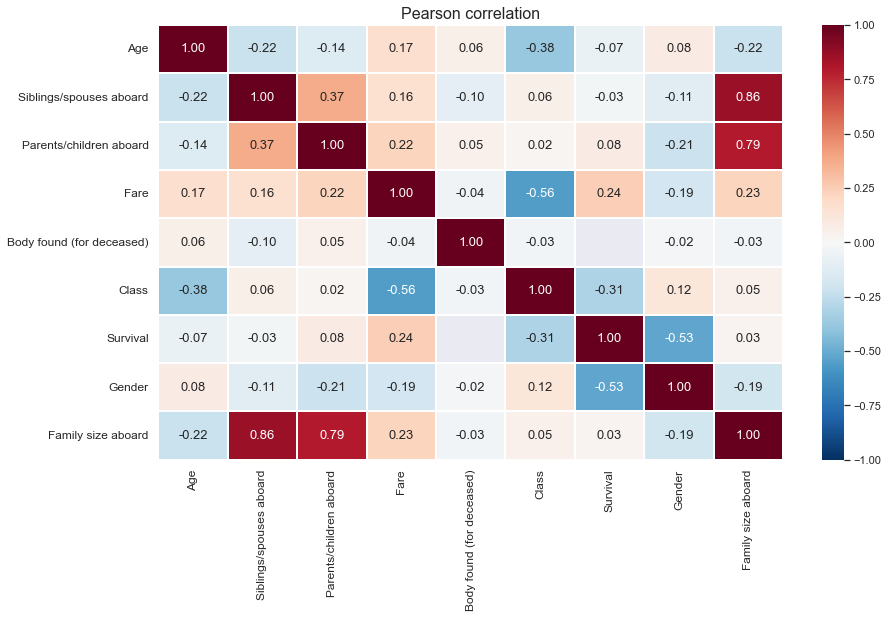

In [29]:
labels = ['Age', 'Siblings/spouses aboard', 'Parents/children aboard', 'Fare', 'Body found (for deceased)', 'Class', 'Survival', 'Gender', 'Family size aboard']
sns.set(rc = {'figure.figsize':(14,8)})
ax = plt.axes()

sns.heatmap(data=data.corr(), 
            cmap="RdBu_r", 
            vmin=-1, vmax=1, 
            annot=True, fmt=".2f", annot_kws={'fontsize':13}, 
            linewidth=1.5,
            xticklabels=labels, yticklabels=labels, ax=ax)

ax.set_title('Pearson correlation', fontdict={'fontsize':16})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

There's a strong correlation observed between survial and gender. Weaker, but moderate correlation exist between class and survival. 

We can also observe a strong correlarion between a fare and ticket class for passengers. An age and a class have a moderate relation. 

What may be suprising, there is a really strong colleration between gender and "siblings/spouses aboard" and "parents/children aboard". We can say that gender is strongly correlated with family members aboard.

Other variables seems to be unrevelant. Let's look closer to some of the attributes. 

The avarage age of travelling people was: 29.8

In [30]:
data['age'].mean()

29.896890699809735

Now let's see how people used to travelled. Alone or with a family? 

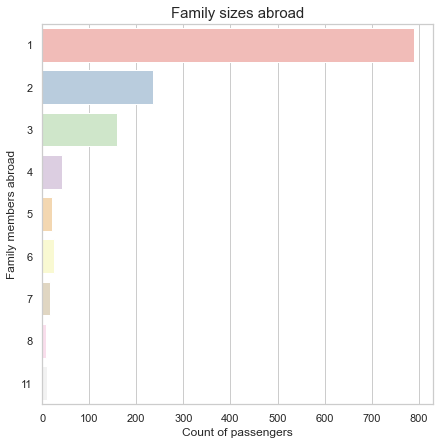

In [31]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(7,7))


sns.countplot(data=data, y='family_size_aboard', palette='Pastel1')
ax.set_title("Family sizes abroad", fontsize=15)
ax.set_xlabel("Count of passengers", fontsize=12)
ax.set_ylabel("Family members abroad", fontsize=12)

plt.show()

You can be curious if you would afford to a ticket into famous "Titanic". Let's look closer into a fare split by classes.

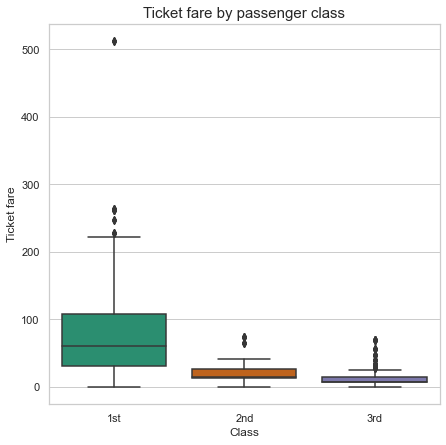

In [32]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.set_style('whitegrid')

sns.boxplot(data=data, x='pclass', y='fare', palette='Dark2')
ax.set_title("Ticket fare by passenger class", fontsize=15)
ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Ticket fare", fontsize=12)

plt.show()

In each class we would find a lucky-unlucky guy who got a ticket for free. Maybe there was a lottery? Another possibility is that data was not complete and unknown values were filled with 0s.

Back on the ground: the average price for ticket was: 33.30$.
Looks cheap? Think about the price considering it was in 1912. 

In [33]:
data['fare'].value_counts().sort_index()

0.0000      17
3.1708       1
4.0125       1
5.0000       1
6.2375       1
            ..
227.5250     5
247.5208     3
262.3750     7
263.0000     6
512.3292     4
Name: fare, Length: 281, dtype: int64

In [34]:
data['fare'].mean()

33.29547928134572

On the chart above we see the high outlier in 1st class. We also know already there are some ticket fees equal to 0. A truncated mean may give a more realistic result.   

In [35]:
scipy.stats.trim_mean(data['fare'], 0.1)

21.628434890371786

Now after outliers have been removed mean is a way lower.
To have a better perspective we should also check a median, which is still below the mean. It means there are still some tickets with really small price. 
Mode is telling that the most popular prcice was $8.05.

In [36]:
statistics.median(data['fare'])

16.1

In [37]:
statistics.mode(data['fare'])

8.05

Going forward we can try to place people by the age into passanger classes to check if you would have a chance to be in the 1st class (considering we don't really know a reallity of payment in 1912):

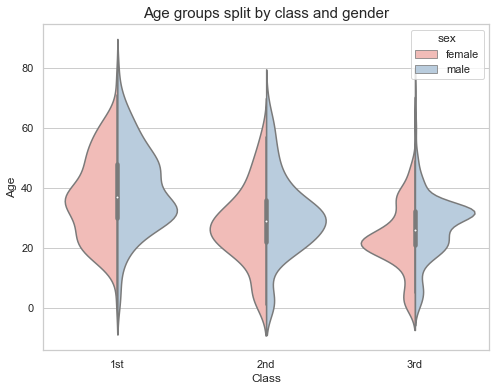

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.set_style('whitegrid')

sns.violinplot(data=data, x='pclass', y='age', hue='sex', palette='Pastel1', split=True)
ax.set_title("Age groups split by class and gender", fontsize=15)
ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Age", fontsize=12)

plt.show()

How does the survival ratio looks like?

In [39]:
data['survived'].value_counts()

No     809
Yes    500
Name: survived, dtype: int64

In [40]:
len(data[data['survived'] == 'Yes'])*100/len(data)

38.19709702062643

Survival ratio is: 38.2

Let's look at this a little closer and consider some extra factors:

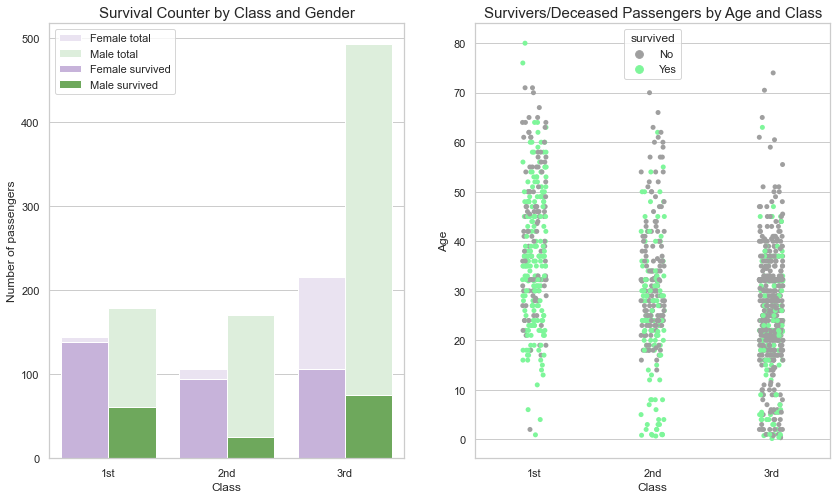

In [41]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,8))
sns.set_style('whitegrid')

sns.countplot(x='pclass', hue='sex', data=data, ax=ax1, palette=["#EAE1F3", "#DAF1D9"])
sns.countplot(x='pclass', hue='sex', data=survived, ax=ax1, palette=['#C7ADE0', '#67B450'])
ax1.legend(['Female total', 'Male total', 'Female survived', 'Male survived'])

ax1.set_title('Survival Counter by Class and Gender', fontsize=15)
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Number of passengers', fontsize=12)

sns.stripplot(x='pclass', y='age', data=data, hue='survived', ax=ax2, palette=['#9F9F9F', '#7EF69A'])
ax2.set_title("Survivers/Deceased Passengers by Age and Class", fontsize=15)
ax2.set_xlabel("Class", fontsize=12)
ax2.set_ylabel("Age", fontsize=12)

plt.show()

Looking at the upper plot we can observe that rate of survival for womens is much higher than for mens. There's also a connection between survival rate depending on class. Chance for staying alive is the higher, the higher class ticket a person have.

We can also try to check a relation between age and survival to check if there was applied a rule saying "women and children first". Doing this we should remember that any blank age values were populated with an average age of passengers based on name prefix.

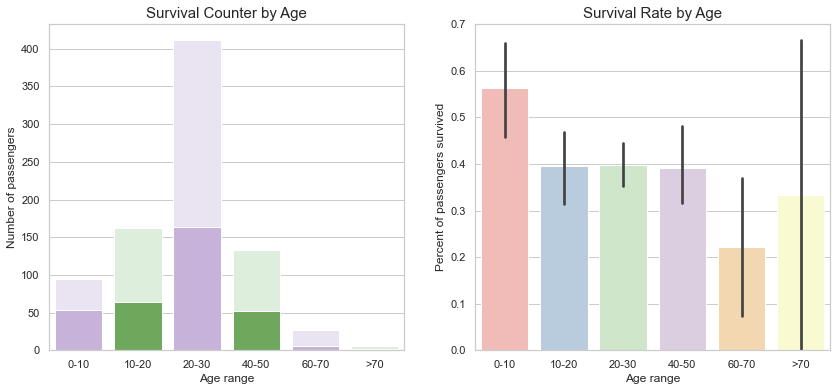

In [42]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(14,6))
sns.set_style('whitegrid')

sns.countplot(x='age_range', data=data, ax=ax1, palette=["#EAE1F3", "#DAF1D9"], order=['0-10', '10-20', '20-30', '40-50', '60-70', '>70'])
sns.countplot(x='age_range', data=survived, ax=ax1, palette=['#C7ADE0', '#67B450'], order=['0-10', '10-20', '20-30', '40-50', '60-70', '>70'])

ax1.set_title('Survival Counter by Age', fontsize=15)
ax1.set_xlabel('Age range', fontsize=12)
ax1.set_ylabel('Number of passengers', fontsize=12)


sns.barplot(data=data, x='age_range', y='survived_num', ax=ax2, order=['0-10', '10-20', '20-30', '40-50', '60-70', '>70'], palette="Pastel1")

ax2.set_title('Survival Rate by Age', fontsize=15)
ax2.set_xlabel('Age range', fontsize=12)
ax2.set_ylabel('Percent of passengers survived', fontsize=12)
plt.show()

Most of survived people were in their middle age. To get more detailed information about the survival rate based on age group this must be showed in percentages. Looking at the above - the rule acctually had a place during the "Titanic Disaster". Survival rate is getting decrease with the age.

Speaking of death - we should check how many bodies were found.

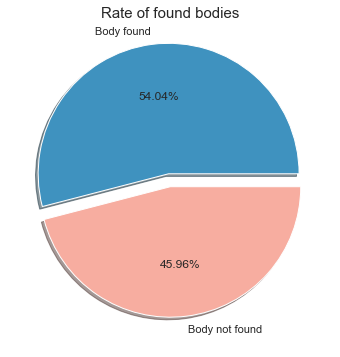

In [43]:
labels = ['Body found', 'Body not found']
sizes = [len(not_survived), len(not_survived[not_survived['body'].isnull()])]
explode = (0.1, 0)

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%', shadow=True, colors=['#3F92BF', '#F7ADA0'])
ax.set_title("Rate of found bodies", fontsize=15)

plt.show()

In [44]:
len(not_survived[not_survived['body'].isnull()])*100/len(not_survived)

85.04326328800988

85.04% of bodies were not found.

Basing on the famous movie we may be wondering if all of the survivors had a boat?

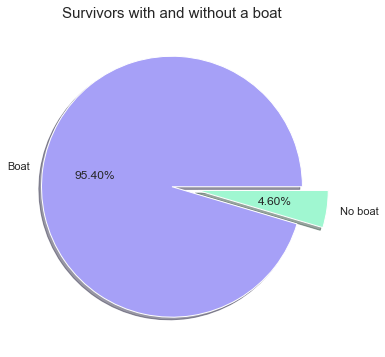

In [45]:
labels = ['Boat', 'No boat']
sizes = [survived['boat'].dropna().count(), len(survived[survived['boat'].isnull()])]
explode = (0, 0.2)

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%', shadow=True, colors=['#A6A0F7', '#A0F7D1'])
ax.set_title("Survivors with and without a boat", fontsize=15)
plt.show()

# Titanic survival prediction

In [46]:
features = ['pclass_num', 'sex_num', 'age', 'family_size_aboard']

X = data[features]
y = data['survived_num']

In [47]:
survival_model = DecisionTreeClassifier(random_state=1)

In [48]:
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)

In [49]:
survival_model.fit(train_X, train_y)

DecisionTreeClassifier(random_state=1)

In [50]:
survival_predictions = survival_model.predict(test_X)

In [51]:
mi_score = mutual_info_classif(X,y, random_state=1)

In [52]:
zipped = zip(X.columns, mi_score)

In [53]:
print("Correlation between variables and the outcome (MI score):")
for x, y in zipped:
    print("MI score for variable {} is {:0.2f}.".format(x, y))

Correlation between variables and the outcome (MI score):
MI score for variable pclass_num is 0.04.
MI score for variable sex_num is 0.14.
MI score for variable age is 0.05.
MI score for variable family_size_aboard is 0.03.


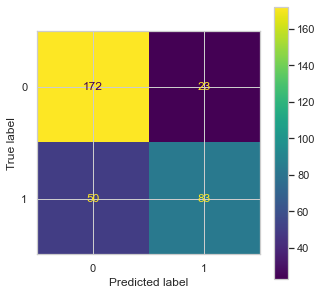

In [54]:
fig, ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(survival_model, test_X, test_y, ax=ax) 
plt.show()

In [55]:
accuracy = accuracy_score(survival_predictions, test_y)

In [56]:
print("Accuracy score is: {}.".format(accuracy))

Accuracy score is: 0.7774390243902439.


In [57]:
print(classification_report(test_y, survival_predictions))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       195
           1       0.78      0.62      0.69       133

    accuracy                           0.78       328
   macro avg       0.78      0.75      0.76       328
weighted avg       0.78      0.78      0.77       328



Let's try to find a better model:




REASULT FOR 5 MAX LEAF NODES:


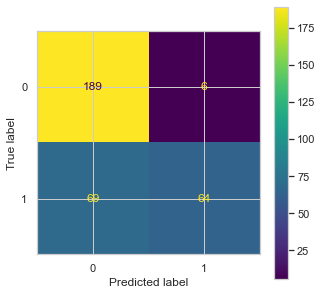

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       195
           1       0.91      0.48      0.63       133

    accuracy                           0.77       328
   macro avg       0.82      0.73      0.73       328
weighted avg       0.81      0.77      0.75       328




REASULT FOR 10 MAX LEAF NODES:


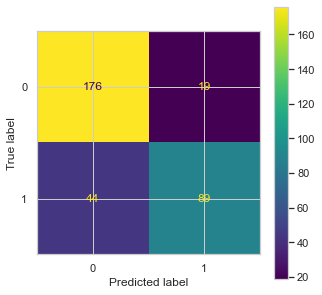

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       195
           1       0.82      0.67      0.74       133

    accuracy                           0.81       328
   macro avg       0.81      0.79      0.79       328
weighted avg       0.81      0.81      0.80       328




REASULT FOR 15 MAX LEAF NODES:


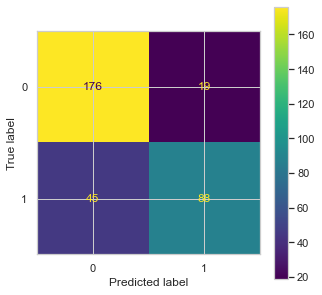

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       195
           1       0.82      0.66      0.73       133

    accuracy                           0.80       328
   macro avg       0.81      0.78      0.79       328
weighted avg       0.81      0.80      0.80       328




REASULT FOR 20 MAX LEAF NODES:


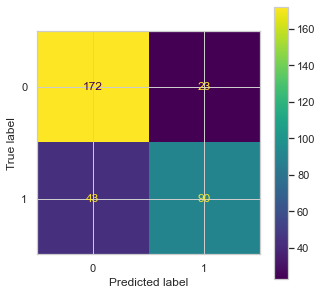

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       195
           1       0.80      0.68      0.73       133

    accuracy                           0.80       328
   macro avg       0.80      0.78      0.79       328
weighted avg       0.80      0.80      0.80       328




REASULT FOR 25 MAX LEAF NODES:


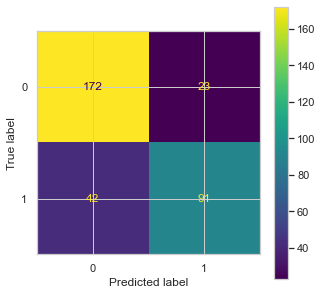

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       195
           1       0.80      0.68      0.74       133

    accuracy                           0.80       328
   macro avg       0.80      0.78      0.79       328
weighted avg       0.80      0.80      0.80       328




REASULT FOR 30 MAX LEAF NODES:


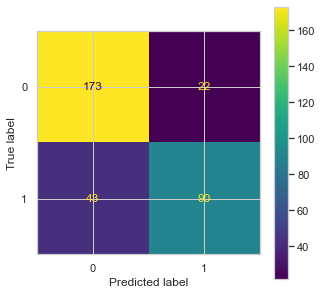

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       195
           1       0.80      0.68      0.73       133

    accuracy                           0.80       328
   macro avg       0.80      0.78      0.79       328
weighted avg       0.80      0.80      0.80       328




REASULT FOR 50 MAX LEAF NODES:


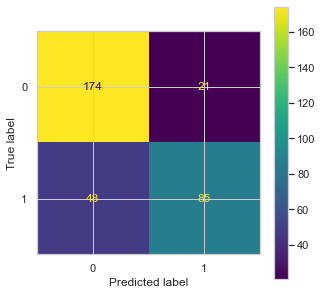

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       195
           1       0.80      0.64      0.71       133

    accuracy                           0.79       328
   macro avg       0.79      0.77      0.77       328
weighted avg       0.79      0.79      0.78       328



In [58]:
for max_leaf_nodes in [5, 10, 15, 20, 25, 30, 50]:
    print("\n\n\nREASULT FOR {} MAX LEAF NODES:".format(max_leaf_nodes))
    survival_model = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=1)
    survival_model.fit(train_X, train_y)
    survival_predictions = survival_model.predict(test_X)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plot_confusion_matrix(survival_model, test_X, test_y, ax=ax) 
    plt.show()
    
    print(classification_report(test_y, survival_predictions))
    




REASULT FOR 3 MIN SAMPLES LEAF:


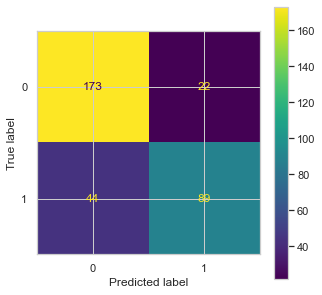

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       195
           1       0.80      0.67      0.73       133

    accuracy                           0.80       328
   macro avg       0.80      0.78      0.78       328
weighted avg       0.80      0.80      0.80       328




REASULT FOR 5 MIN SAMPLES LEAF:


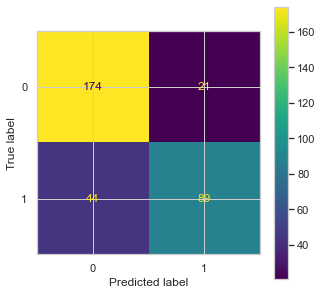

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       195
           1       0.81      0.67      0.73       133

    accuracy                           0.80       328
   macro avg       0.80      0.78      0.79       328
weighted avg       0.80      0.80      0.80       328




REASULT FOR 10 MIN SAMPLES LEAF:


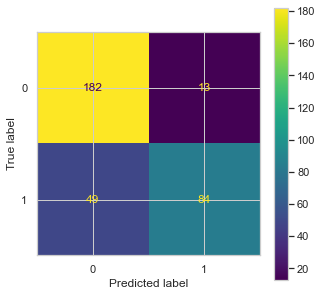

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328




REASULT FOR 20 MIN SAMPLES LEAF:


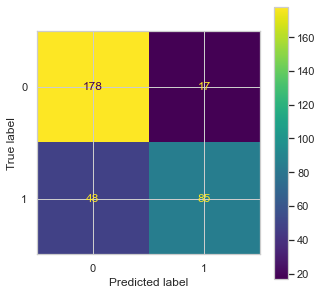

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       195
           1       0.83      0.64      0.72       133

    accuracy                           0.80       328
   macro avg       0.81      0.78      0.78       328
weighted avg       0.81      0.80      0.80       328




REASULT FOR 50 MIN SAMPLES LEAF:


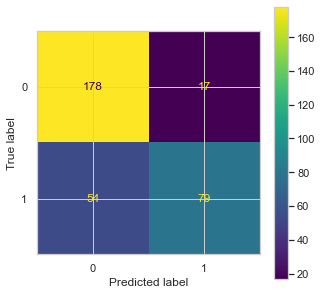

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       195
           1       0.82      0.59      0.69       133

    accuracy                           0.78       328
   macro avg       0.80      0.75      0.76       328
weighted avg       0.79      0.78      0.78       328



In [59]:
for min_samples_leaf in [3, 5, 10, 20, 50]:
    print("\n\n\nREASULT FOR {} MIN SAMPLES LEAF:".format(min_samples_leaf))
    survival_model = DecisionTreeClassifier(max_leaf_nodes=25, min_samples_leaf=min_samples_leaf, random_state=1)
    survival_model.fit(train_X, train_y)
    survival_predictions = survival_model.predict(test_X)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plot_confusion_matrix(survival_model, test_X, test_y, ax=ax) 
    plt.show()
    
    print(classification_report(test_y, survival_predictions))
    




REASULT FOR 5 MAX DEPTH:


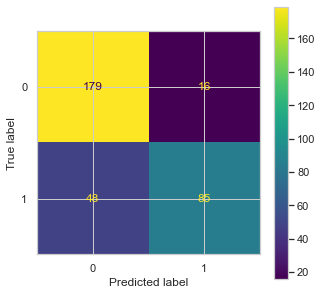

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       195
           1       0.84      0.64      0.73       133

    accuracy                           0.80       328
   macro avg       0.82      0.78      0.79       328
weighted avg       0.81      0.80      0.80       328




REASULT FOR 10 MAX DEPTH:


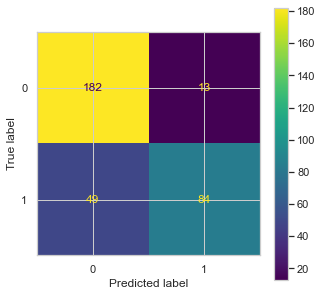

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328




REASULT FOR 15 MAX DEPTH:


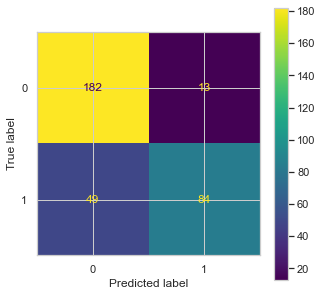

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328




REASULT FOR 20 MAX DEPTH:


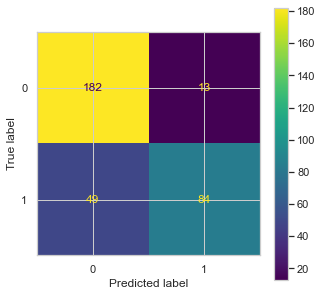

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328




REASULT FOR 25 MAX DEPTH:


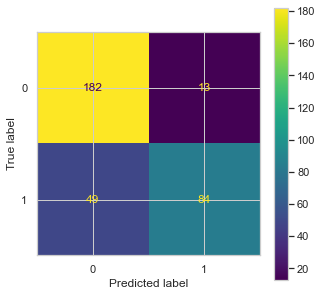

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328




REASULT FOR 50 MAX DEPTH:


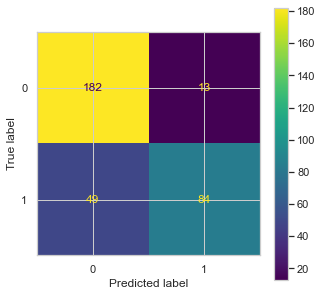

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328




REASULT FOR 100 MAX DEPTH:


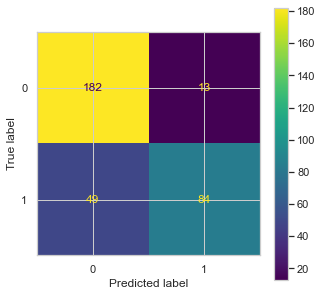

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328



In [60]:
for max_depth in [5, 10, 15, 20, 25, 50, 100]:
    print("\n\n\nREASULT FOR {} MAX DEPTH:".format(max_depth))
    survival_model = DecisionTreeClassifier(max_leaf_nodes=25, min_samples_leaf=10, max_depth=max_depth, random_state=1)
    survival_model.fit(train_X, train_y)
    survival_predictions = survival_model.predict(test_X)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plot_confusion_matrix(survival_model, test_X, test_y, ax=ax) 
    plt.show()
    
    print(classification_report(test_y, survival_predictions))


Here's the final model:

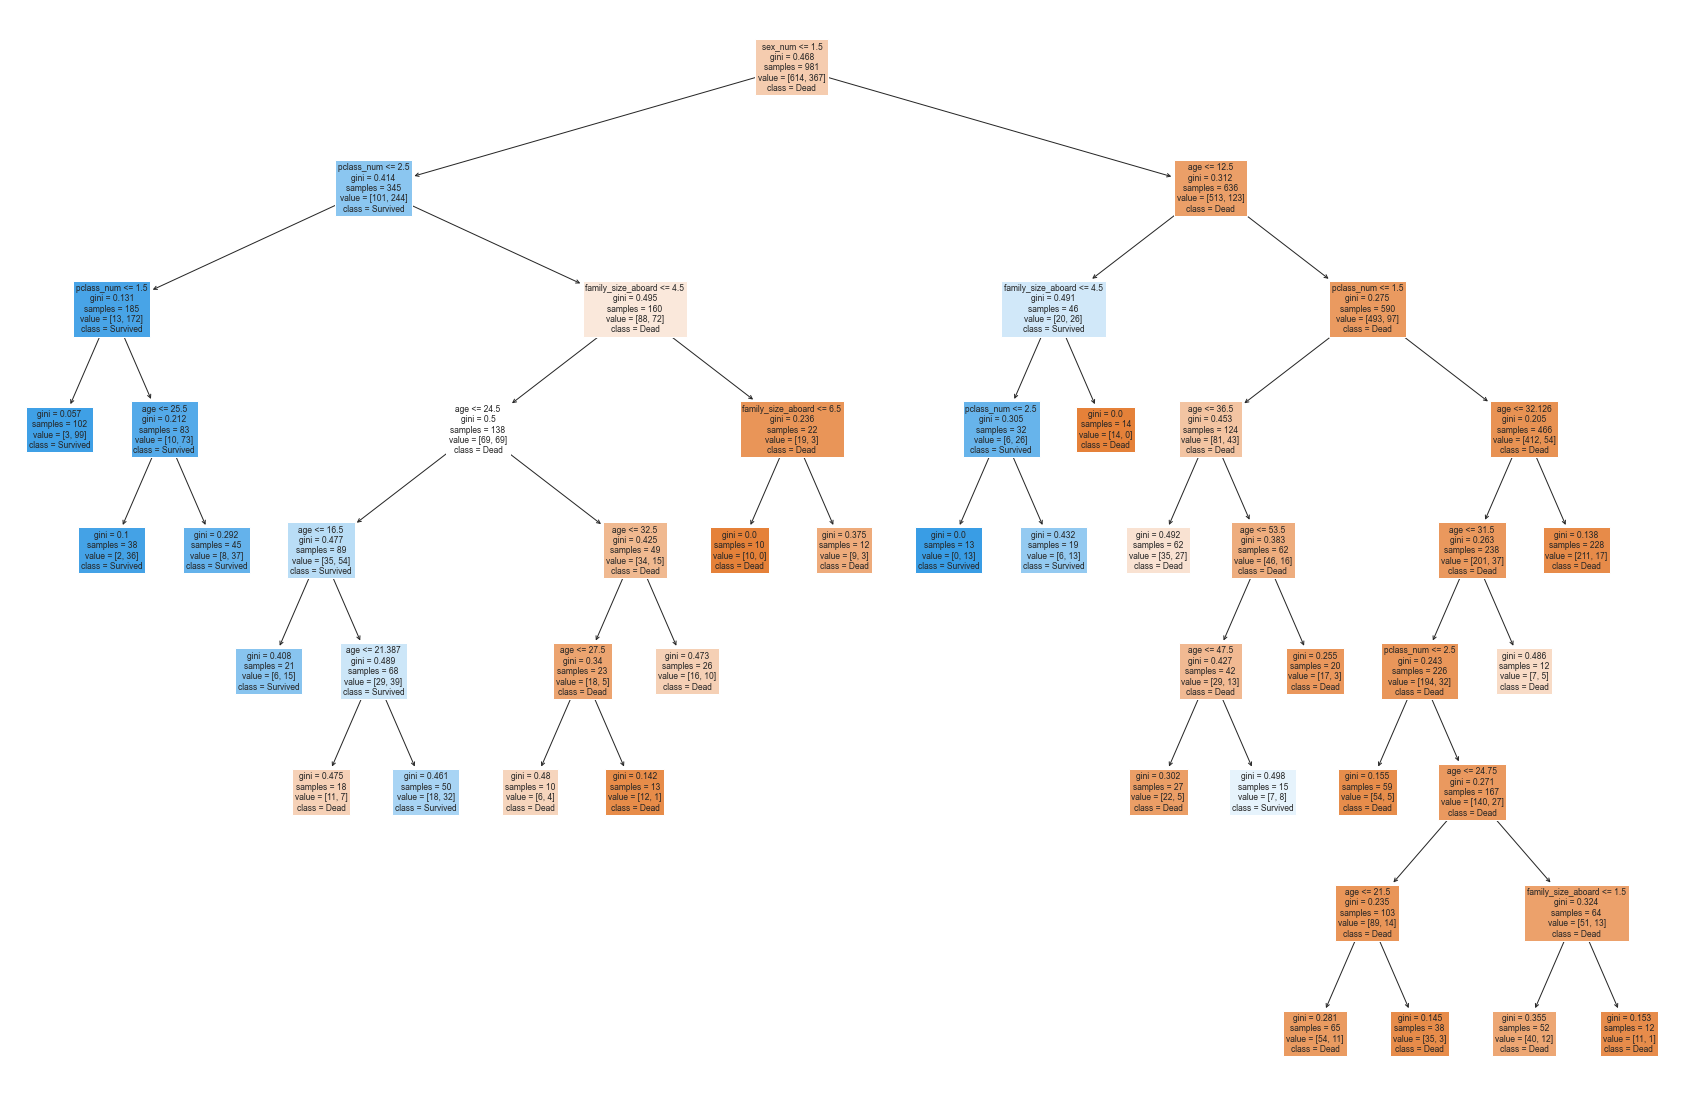

In [67]:
survival_model = DecisionTreeClassifier(max_leaf_nodes=25, min_samples_leaf=10, max_depth=25, random_state=1)
survival_model.fit(train_X, train_y)
survival_predictions = survival_model.predict(test_X)
    
fig = plt.figure(figsize=(30,20))
_ = plot_tree(survival_model, feature_names=X.columns,  
                   class_names=['Dead', 'Survived'],
                   filled=True)

plt.savefig("DecisionTree.png")

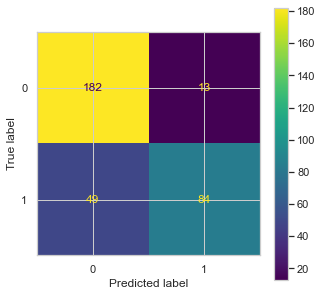

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       195
           1       0.87      0.63      0.73       133

    accuracy                           0.81       328
   macro avg       0.83      0.78      0.79       328
weighted avg       0.82      0.81      0.80       328



In [62]:
fig, ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(survival_model, test_X, test_y, ax=ax) 
plt.show()
    
print(classification_report(test_y, survival_predictions))

Now I can find out if hypothetically I would survive the Titanic meet with the iceberg.

In [63]:
prediction_1 = pd.DataFrame({'pclass_num': [3], 'sex_num' : [1], 'age' : [26], 'family_size_aboard' : [1]})

In [64]:
prediction_1

,pclass_num,sex_num,age,family_size_aboard
0,3,1,26,1


In [65]:
survival_model.predict(prediction_1)

array([0])

Well, "0" means me being dead. Unlucky me! Better keep away from the Ocean!